# COMP 551 - Mini-project 4
Group 62

In [11]:
import keras
import numpy as np
from sklearn import datasets
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import pandas as pd
import seaborn as sns
import os
import pylab

np.random.seed(1234)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/mini_proj4/'
#use folder that mnist data subset is stored

Mounted at /content/drive


## Dataset - Using the MNIST subset provided by the author, Olivetti Faces dataset from keras, or full MNIST subset from keras. 

In [4]:
X = np.loadtxt(path+"mnist2500_X.txt")
labels = np.loadtxt(path+"mnist2500_labels.txt")

In [ ]:
#MNIST from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_train = np.reshape(x_train, (-1, 784)).astype('float32')
x_test = np.reshape(x_test, (-1, 784)).astype('float32')
print(x_train.shape, x_test.shape)
x_train, x_test = x_train/255.0, x_test/255.0


data_slice = 6000
X = x_train[:data_slice,:]
labels = y_train[:data_slice]

print(labels.size)


(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 784) (10000, 784)
6000


In [12]:
faces = datasets.fetch_olivetti_faces()

X = faces.data
labels = faces.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
print(X.shape, labels.shape)
print(np.amin(X), np.amax(X))
print(labels)

(6000, 784) (6000, 10)
0.0 1.0
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


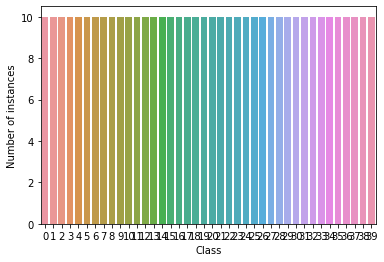

In [ ]:
df = pd.DataFrame(data=labels, columns=['class'])
ax = sns.countplot(x='class', data=df)
ax.set(xlabel='Class', ylabel='Number of instances')
plt.show()

#Code from the author

Changed initialize values in this block of code in the tsne function

In [13]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    #Y = np.random.uniform(low=-1.0,high=1.0,size=(n,no_dims)) for figure 6d
    #Y = np.random.randn(n, no_dims) multipied by variances of 0.1,10, and 30 for figures in 6 (initialization)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

## t-SNE 

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.402726
Iteration 10: error is 21.959618
Iteration 20: error is 19.222380
Iteration 30: error is 16.638761
Iteration 40: error is 15.809499
Iteration 50: error is 15.578691
Iteration 60: error is 15.459110
Iteration 70: error is 15.379433
Iteration 80: error is 15.345808
Iteration 90: error is 15.320156
Iteration 100: error is 15.305094
Iteration 110: error is 2.151136
Iteration 120: error is 1.874544
Iteration 130: error is 1.689130
Iteration 140: error is 1.559984
Iteration 150: error is 1.465826
Iteration 160: error is 1.394499
Iteration 170: error is 1.338593
It

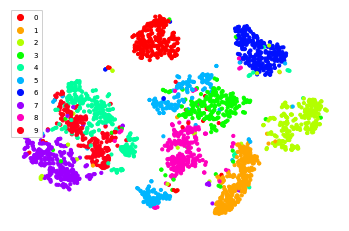

CPU times: user 7min 14s, sys: 1min 48s, total: 9min 2s
Wall time: 7min


In [10]:
%%time
#for mnist data
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne(X, 2, 30, perplexity=30.0)

    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()



This block runs when using Olivetti Faces dataset due to the change of markers since there are 40 different labels, all subsequent code blocks that have faces dataset commented in will only run when they are the loaded dataset

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.652874
Iteration 10: error is 14.580131
Iteration 20: error is 13.582749
Iteration 30: error is 13.440453
Iteration 40: error is 13.477145
Iteration 50: error is 13.474539
Iteration 60: error is 13.488730
Iteration 70: error is 13.507428
Iteration 80: error is 13.445911
Iteration 90: error is 13.474103
Iteration 100: error is 13.494549
Iteration 110: error is 1.099189
Iteration 120: error is 0.660165
Iteration 130: error is 0.541601
Iteration 140: error is 0.491392
Iteration 150: error is 0.467919
Iteration 160: error is 0.449240
Iteration 170: error is 0.438182
Iteration 180: error is 0.431885
Iteration 190: error is 0.428030
Iteration 200: error is 0.425623
Iteration 210: error is 0.423984
Iteration 220: error is 0.422772
Iteration 230: er

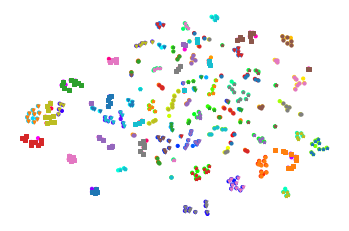

In [14]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne(X, 2, 30, perplexity=30.0)

    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv') 
    markz = ['o','*','v','s']
    for i,m in enumerate(markz):
      for j in range(10):
      #scatter = ax.scatter(Y[(100*i):(100*i+99), 0], Y[(100*i):(100*i+99), 1], s=10, marker=m, cmap='viradis')
        scatter = ax.scatter(Y[(100*i+10*j):(100*i+10*j+9), 0], Y[(100*i+10*j):(100*i+10*j+9), 1], s=10, marker=m)  
        
    plt.axis('off')
    plt.show()

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.499815
Iteration 10: error is 29.464825
Iteration 20: error is 27.482068
Iteration 30: error is 23.941534
Iteration 40: error is 21.801293
Iteration 50: error is 20.778959
Iteration 60: error is 20.100578
Iteration 70: error is 19.576857
Iteration 80: error is 19.125907
Iteration 90: error is 18.769228
Iteration 100: error is 18.474333
Iteration 110: error is 3.078321
Iteration 120: error is 2.914534
Iteration 130: error is 2.735911
Iteration 140: error is 2.556803
Iteration 150: error is 2.393003
Iteration 160: error is 2.255064
Iteration 170: error is 2.149496
Iteration 180: error is 2.066135
Iteration 190: error is 1.992290
Iteration 200: error is 1.925222
Iteration 210: error

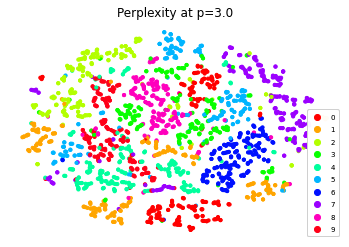

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.573319
Iteration 10: error is 22.162202
Iteration 20: error is 20.179806
Iteration 30: error is 17.225935
Iteration 40: error is 16.119333
Iteration 50: error is 15.810175
Iteration 60: error is 15.675883
Iteration 70: error is 15.640604
Iteration 80: error is 15.626693
Iteration 90: error is 15.622787
Iteration 100: error is 15.621422
Iteration 110: error is 2.198867
Iteration 120: error is 1.906374
Iteration 130: error is 1.716669
Iteration 140: error is 1.587208
Iteration 150: error is 1.493126
Iteration 160: error is 1.421041
Iteration 170: error is 1.364763
Iteration 180: error is 1.319488
Iteration 190: error is 1.282341
Iteration 200: error is 1.251333
Iteration 210: error

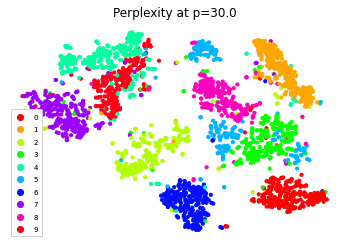

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 3.830213
Iteration 10: error is 13.660070
Iteration 20: error is 13.530994
Iteration 30: error is 12.945628
Iteration 40: error is 13.063443
Iteration 50: error is 13.088110
Iteration 60: error is 13.052010
Iteration 70: error is 13.062953
Iteration 80: error is 13.065328
Iteration 90: error is 13.062104
Iteration 100: error is 13.062633
Iteration 110: error is 1.297235
Iteration 120: error is 0.922526
Iteration 130: error is 0.806902
Iteration 140: error is 0.751709
Iteration 150: error is 0.720385
Iteration 160: error is 0.701570
Iteration 170: error is 0.689264
Iteration 180: error is 0.680751
Iteration 190: error is 0.674825
Iteration 200: error is 0.669747
Iteration 210: error

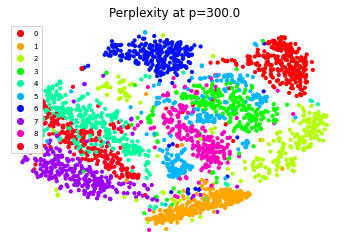

In [5]:
#for perplexity experiments on MNIST data, make sure to have MNIST data loaded as X and Y to run this code 
perp = [3.0,30.0,300.0]

for p in perp:
  Y = tsne(X, 2, 30, perplexity=p)
  #pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
  #pylab.title('Perpexity at p='+str(p))
  #pylab.show()
  fig, ax = plt.subplots()
  scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
  plt.axis('off')
  plt.title('Perplexity at p='+str(p))
  legend = ax.legend(*scatter.legend_elements(), fontsize=7)
  ax.add_artist(legend)
  plt.show()

## Other methods

### Isomap

faces dataset

Preprocessing the data using PCA...
9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199
209
219
229
239
249
259
269
279
289
299
309
319
329
339
349
359
369
379
389
399


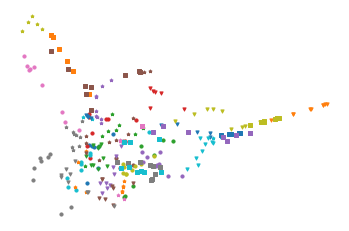

CPU times: user 2min 11s, sys: 25.4 s, total: 2min 36s
Wall time: 1min 26s


In [5]:
%%time 
from sklearn.manifold import Isomap
#for faces dataset isomap
embedding = Isomap(n_neighbors=3, n_components=2)
X_reduced = pca(X).real
Y = embedding.fit_transform(X)
#pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#fig, ax = plt.subplots()
#scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
#plt.axis('off')
#plt.show()
fig, ax = plt.subplots()
markz = ['o','*','v','s']
for i,m in enumerate(markz):
  for j in range(10):
      #scatter = ax.scatter(Y[(100*i):(100*i+99), 0], Y[(100*i):(100*i+99), 1], s=10, marker=m, cmap='viradis')
    scatter = ax.scatter(Y[(100*i+10*j):(100*i+10*j+9), 0], Y[(100*i+10*j):(100*i+10*j+9), 1], s=10, marker=m)  
plt.axis('off')
plt.show()

### LLE
faces dataset


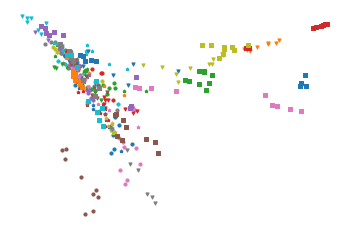

CPU times: user 243 ms, sys: 11.1 ms, total: 254 ms
Wall time: 268 ms


In [6]:
%%time 
#for faces data set
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_neighbors=12, n_components=2)
Y = embedding.fit_transform(X_reduced)
#pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#fig, ax = plt.subplots()
#scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
#plt.axis('off')
#plt.show()
fig, ax = plt.subplots()
markz = ['o','*','v','s']
for i,m in enumerate(markz):
  for j in range(10):
    scatter = ax.scatter(Y[(100*i+10*j):(100*i+10*j+9), 0], Y[(100*i+10*j):(100*i+10*j+9), 1], s=10, marker=m)  

plt.axis('off')
plt.show()

### Sammon mapping

faces dataset

Implementation by Tom Pollard https://github.com/tompollard/sammon/blob/master/sammon.py

In [7]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

epoch = 1 : E = 0.1216065493
epoch = 2 : E = 0.1159535203
epoch = 3 : E = 0.1156604838
epoch = 4 : E = 0.1156181474
epoch = 5 : E = 0.1143754014
epoch = 6 : E = 0.1085882749
epoch = 7 : E = 0.1056629318
epoch = 8 : E = 0.1013270294
epoch = 9 : E = 0.0995926282
epoch = 10 : E = 0.0940846311
epoch = 11 : E = 0.0921942596
epoch = 12 : E = 0.0880116289
epoch = 13 : E = 0.0860318224
epoch = 14 : E = 0.0848040859
epoch = 15 : E = 0.0668933405
epoch = 16 : E = 0.0664265539
epoch = 17 : E = 0.0662724100
epoch = 18 : E = 0.0608473082
epoch = 19 : E = 0.0606913242
epoch = 20 : E = 0.0600981367
epoch = 21 : E = 0.0519310225
epoch = 22 : E = 0.0518996639
epoch = 23 : E = 0.0513729209
epoch = 24 : E = 0.0496102883
epoch = 25 : E = 0.0492039382
epoch = 26 : E = 0.0491758284
epoch = 27 : E = 0.0488845290
epoch = 28 : E = 0.0488303502
epoch = 29 : E = 0.0480368288
epoch = 30 : E = 0.0478123503
epoch = 31 : E = 0.0477827307
epoch = 32 : E = 0.0476814109
epoch = 33 : E = 0.0475259918
epoch = 34 : E = 0.

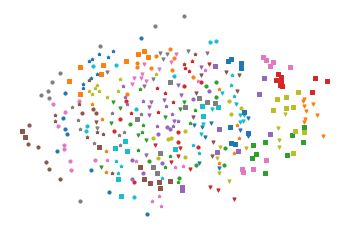

CPU times: user 13.5 s, sys: 4.71 s, total: 18.2 s
Wall time: 9.94 s


In [8]:
%%time
#for faces dataset
[Y, E] = sammon(X, 2, maxiter = 1000)
#pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)

fig, ax = plt.subplots()
markz = ['o','*','v','s']
for i,m in enumerate(markz):
  for j in range(10):
    scatter = ax.scatter(Y[(100*i+10*j):(100*i+10*j+9), 0], Y[(100*i+10*j):(100*i+10*j+9), 1], s=10, marker=m)  

plt.axis('off')
plt.show()